In [1]:
import sys
import os
import pandas as pd
import torch
import json
import numpy as np
import matplotlib.pyplot as plt
from tqdm import TqdmTypeError
from torch.utils.tensorboard import SummaryWriter
    
# navigates to the main project folder
project_root = os.path.abspath(os.path.join(os.path.dirname("__file__"), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)    
    
from src.utils.data_loading import *
from src.utils.plotting import *
from src.utils.config_managing import *
from src.behavior_cloning import BC

import gymnasium as gym
from gymnasium.envs.registration import register

In [2]:
rb_observations, rb_next_observations, rb_actions, rb_rewards, rb_dones = load_data()
fp_observations, fp_next_observations, fp_actions, fp_rewards, fp_dones = load_data('../data/final_policy.npz')
rb_df = load_data_as_df(rb_observations, rb_next_observations, rb_actions, rb_rewards, rb_dones)
fp_df = load_data_as_df(fp_observations, fp_next_observations, fp_actions, fp_rewards, fp_dones)

In [3]:
fp_rewards = []

env_test_params = load_env_test_config_file()
with open(f"../logs/fp_bc/best_hyperparams.txt", "r") as file:
    hyperparams_dict_text = file.readline().strip()
    hyperparams_dict_text = hyperparams_dict_text[22:].replace("'", '"')
    best_model_hyperparams = json.loads(hyperparams_dict_text)

BC_model = BC(input_neurons=best_model_hyperparams['input_neurons'],
              hidden_neurons=best_model_hyperparams['hidden_neurons'],
              num_hidden_layers=best_model_hyperparams['num_hidden_layers'],
              out_neurons=best_model_hyperparams['out_neurons'],
              activation_function=torch.nn.ReLU())
BC_model.load_state_dict(torch.load(f"../models/fp_BC_best_model.pth"))
BC_model.eval()


log_subfolder = '../logs/fp_bc_trained_performance_test/'
tensorboard_log_subfolder = os.path.join(log_subfolder, 'tensorboard')
if not os.path.exists(log_subfolder):
    os.makedirs(log_subfolder)
if not os.path.exists(tensorboard_log_subfolder):
    os.makedirs(tensorboard_log_subfolder)
log_writer = SummaryWriter(log_dir=tensorboard_log_subfolder)

register(
    id="LunarLander-v2",
    entry_point="gymnasium.envs.box2d:LunarLander",
    max_episode_steps=1000,
    reward_threshold=200,
)

env = gym.make("LunarLander-v2")
env.action_space.seed(env_test_params['seed'])

for episode in tqdm(range(env_test_params['num_episodes'])):
    state, info = env.reset()
    done = False
    total_reward = 0

    while not done:
        model_output = BC_model(torch.tensor(state))
        action = np.argmax(model_output.detach().numpy())
        next_state, reward, terminated, truncated, info = env.step(action)

        total_reward += reward
        done = terminated or truncated
        state = next_state
    
    log_writer.add_scalar("Episode Reward", total_reward, episode)
    fp_rewards.append(total_reward)
    
log_writer.add_scalar("Reward (Mean)", np.mean(fp_rewards), 0)
log_writer.add_scalar("Reward (std)", np.std(fp_rewards), 0)

log_writer.flush()
log_writer.close()
env.close()

c:\Users\miroa\AppData\Local\Programs\Python\Python310\lib\site-packages\gymnasium\envs\registration.py:517: DeprecationWarning: WARN: The environment LunarLander-v2 is out of date. You should consider upgrading to version `v3`.
  logger.deprecation(
100%|██████████| 1000/1000 [10:06<00:00,  1.65it/s]


In [4]:
rb_rewards = []

env_test_params = load_env_test_config_file()
with open(f"../logs/rb_bc/best_hyperparams.txt", "r") as file:
    hyperparams_dict_text = file.readline().strip()
    hyperparams_dict_text = hyperparams_dict_text[22:].replace("'", '"')
    best_model_hyperparams = json.loads(hyperparams_dict_text)

BC_model = BC(input_neurons=best_model_hyperparams['input_neurons'],
              hidden_neurons=best_model_hyperparams['hidden_neurons'],
              num_hidden_layers=best_model_hyperparams['num_hidden_layers'],
              out_neurons=best_model_hyperparams['out_neurons'],
              activation_function=torch.nn.ReLU())
BC_model.load_state_dict(torch.load(f"../models/rb_BC_best_model.pth"))
BC_model.eval()


log_subfolder = '../logs/rb_bc_trained_performance_test/'
tensorboard_log_subfolder = os.path.join(log_subfolder, 'tensorboard')
if not os.path.exists(log_subfolder):
    os.makedirs(log_subfolder)
if not os.path.exists(tensorboard_log_subfolder):
    os.makedirs(tensorboard_log_subfolder)
log_writer = SummaryWriter(log_dir=tensorboard_log_subfolder)

register(
    id="LunarLander-v2",
    entry_point="gymnasium.envs.box2d:LunarLander",
    max_episode_steps=1000,
    reward_threshold=200,
)
    
env = gym.make("LunarLander-v2")
env.action_space.seed(env_test_params['seed'])

for episode in tqdm(range(env_test_params['num_episodes'])):
    state, info = env.reset()
    done = False
    total_reward = 0

    while not done:
        model_output = BC_model(torch.tensor(state))
        action = np.argmax(model_output.detach().numpy())
        next_state, reward, terminated, truncated, info = env.step(action)

        total_reward += reward
        done = terminated or truncated
        state = next_state
    
    log_writer.add_scalar("Episode Reward", total_reward, episode)
    rb_rewards.append(total_reward)
    
log_writer.add_scalar("Reward (Mean)", np.mean(rb_rewards), 0)
log_writer.add_scalar("Reward (std)", np.std(rb_rewards), 0)

log_writer.flush()
log_writer.close()
env.close()

c:\Users\miroa\AppData\Local\Programs\Python\Python310\lib\site-packages\gymnasium\envs\registration.py:642: UserWarning: WARN: Overriding environment LunarLander-v2 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
100%|██████████| 1000/1000 [05:04<00:00,  3.29it/s]


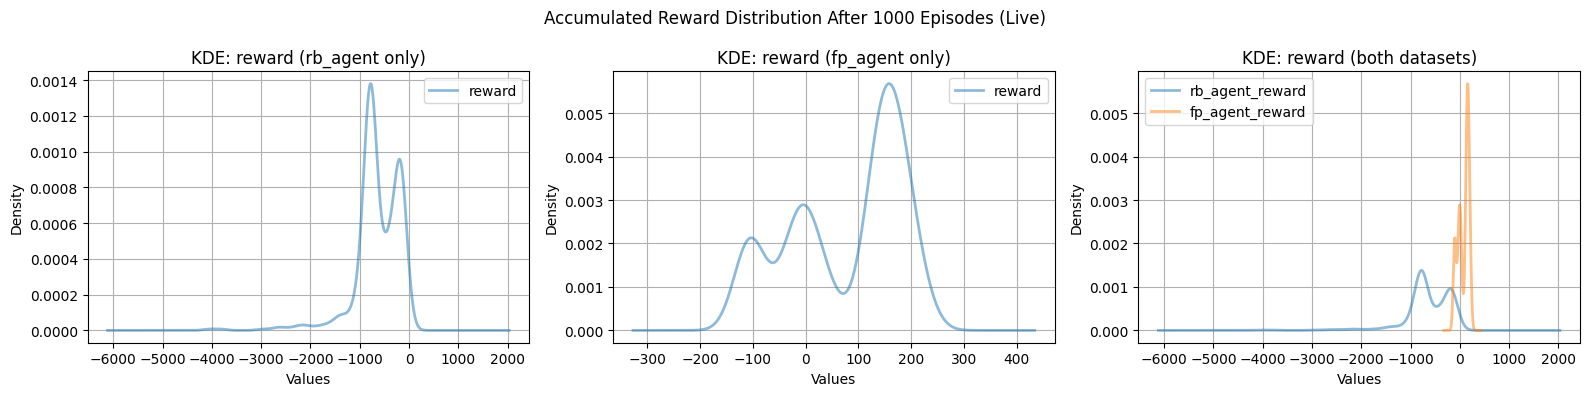

In [ ]:
rb_rewards_df = pd.DataFrame(rb_rewards, columns=['reward'])
fp_rewards_df = pd.DataFrame(fp_rewards, columns=['reward'])

rb_fp_combined_fig = plot_univariate_analysis(
        df1_name = 'rb_agent',
        df2_name = 'fp_agent',
        df1=rb_rewards_df,
        df2=fp_rewards_df,
        num_columns=3,
        custom_title='Accumulated Reward Distribution After 1000 Episodes (Live)',
        kde_kwargs={'linewidth': 2, 'alpha': 0.5, 'grid': True},
        hist_kwargs={'alpha': 0.5, 'grid': True, 'bins': [-0.5, 0.5, 1.5, 2.5, 3.5],'align':'mid', 'rwidth': 0.8},
        f_size=(16,4))